In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("enron_emails.csv")

# Display first few rows
print(df.head())

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


In [2]:
import re
from transformers import pipeline

# Load NER model
ner_pipeline = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple", device=0)

def extract_signature(email_body):
    # Step 1: Use NER to extract entities (name, job title)
    ner_results = ner_pipeline(email_body)
    
    # Step 2: Extract PERSON and ORG entities
    person_name = []
    job_title = []
    
     # Keywords to detect job titles
    title_keywords = ["CEO", "Manager", "Director", "Analyst", "Officer", "President", "Engineer", "Coordinator", "Supervisor", "Specialist", "Consultant", "Associate", "Administrator", "Executive", "Lead", "Head", "Chief"]

    for entity in ner_results:
        if entity["entity_group"] == "PER":
            person_name.append(entity["word"].replace("▁", ""))
        elif entity["entity_group"] in ["ORG", "MISC"] and any(t in entity["entity_group"] for t in title_keywords):
            job_title.append(entity["word"].replace("▁", ""))
    
    full_name = " ".join(person_name) if person_name else "None"
    job_title_text = " ".join(job_title) if job_title else "None"
    
    # Step 3: Extract email using regex
    email_match = re.search(r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}", email_body)
    email_address = email_match.group(0) if email_match else "None"

    # Step 4: Return dictionary output
    # signature_text' and 'sender' columns
    return {
        "signature_text": full_name + " " + job_title_text + " " + email_address,
        "sender": email_address,
        "name": full_name,
        "title": job_title_text,
        "email": email_address
    }


Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# Apply extraction to the first 10 rows
df_subset = df.iloc[:1000].copy()  # Select first 10 rows
df_subset = df_subset["message"].apply(extract_signature)
df_subset.head()
df_subset.info()
# Display the output of emails only
email_values = [signature.get("email") for signature in df_subset]
# Create a DataFrame with signature_text, sender, name and title columns
signature_df = pd.DataFrame(df_subset.tolist(), columns=["signature_text", "sender","name","title"])

# Save the DataFrame to a CSV file
signature_df.to_csv("signature_data.csv", index=False)
print(email_values)
unique_emails = set(email_values)
print(unique_emails)

d:\Dev\Tools\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:440: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


<class 'pandas.core.series.Series'>
RangeIndex: 1000 entries, 0 to 999
Series name: message
Non-Null Count  Dtype 
--------------  ----- 
1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB
['phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@enron.com', 'phillip.allen@

In [4]:
import pandas as pd
import numpy as np

# Load the extracted signature data
df = pd.read_csv("signature_data.csv")

# Drop any missing values for simplicity
#df = df.dropna()
# Feature Engineering: Define shared mailbox detection
def is_shared_mailbox(sender_email, name):
    """
    Heuristic-based label:
    - If sender_email contains the extracted name → Label as 0 (personal)
    - If sender_email is generic (e.g., support@, info@) → Label as 1 (shared mailbox)
    """
    if pd.isna(sender_email) or pd.isna(name):
        return 1  # Treat as shared mailbox if data is missing
    
    sender_name = sender_email.split("@")[0].lower()
    extracted_name = name.lower().replace(" ", "")
    
    return 0 if extracted_name in sender_name else 1

# Apply heuristic function
#df["is_shared_mailbox"] = df.apply(lambda row: is_shared_mailbox(row["sender"], row["signature_text"]), axis=1)

# Recalculate labels
df["is_shared_mailbox"] = df.apply(lambda row: is_shared_mailbox(row["sender"], row["name"]), axis=1)

# Show label distribution
print(df["is_shared_mailbox"].value_counts())

# Save preprocessed data
df.to_csv("processed_signature_data.csv", index=False)

df.head()

is_shared_mailbox
1    998
0      2
Name: count, dtype: int64


,signature_text,sender,name,title,is_shared_mailbox
0,Phillip K Allen Tim Belden Tim Bel Phillip All...,phillip.allen@enron.com,Phillip K Allen Tim Belden Tim Bel Phillip All...,NaN,1
1,Phillip K Allen John J Lavorato John J Lavor P...,phillip.allen@enron.com,Phillip K Allen John J Lavorato John J Lavor P...,NaN,1
2,Phillip K Allen Leah Van Arsdal Phillip Allen ...,phillip.allen@enron.com,Phillip K Allen Leah Van Arsdal Phillip Allen,NaN,1
3,Phillip K Allen Randall L Gay Phillip Allen Ra...,phillip.allen@enron.com,Phillip K Allen Randall L Gay Phillip Allen Ra...,NaN,1
4,Phillip K Allen Greg Piper Phillip Allen None ...,phillip.allen@enron.com,Phillip K Allen Greg Piper Phillip Allen,NaN,1


In [5]:
# Load preprocessed data
df = pd.read_csv("processed_signature_data.csv")

#############
# Calculate the midpoint index
midpoint = len(df) // 2
# Update the first half of the rows in 'col1'
df.loc[:midpoint, 'is_shared_mailbox'] = "0"
#############
df.to_csv("processed_signature_data.csv", index=False)

C:\Users\Piyush\AppData\Local\Temp\ipykernel_14692\1192559474.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:midpoint, 'is_shared_mailbox'] = "0"


              precision    recall  f1-score   support

           0       0.42      0.52      0.47        96
           1       0.43      0.34      0.38       104

    accuracy                           0.42       200
   macro avg       0.43      0.43      0.42       200
weighted avg       0.43      0.42      0.42       200



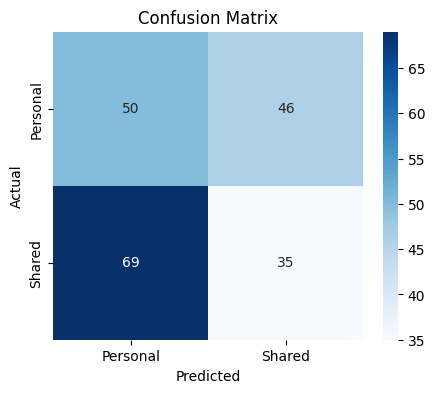

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load preprocessed data
df = pd.read_csv("processed_signature_data.csv")


# Features (signature text) and labels
X = df["signature_text"]
y = df["is_shared_mailbox"]

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a Pipeline: TF-IDF + Logistic Regression
model_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),  # Feature extraction
    ("classifier", LogisticRegression())  # Model
])

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Personal", "Shared"], yticklabels=["Personal", "Shared"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


d:\Dev\Tools\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.35      0.39      0.37        96
           1       0.38      0.35      0.36       104

    accuracy                           0.36       200
   macro avg       0.37      0.37      0.36       200
weighted avg       0.37      0.36      0.36       200



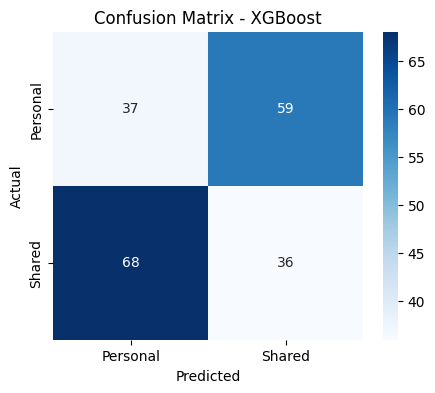

In [7]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Define Pipeline: TF-IDF + XGBoost
xgb_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2))),  # Feature extraction
    ("classifier", XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss"))  # XGBoost
])

# Train the XGBoost model
xgb_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_pipeline.predict(X_test)

# Model Evaluation
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues", xticklabels=["Personal", "Shared"], yticklabels=["Personal", "Shared"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


In [8]:
print(y_train.value_counts())  # Check training class balance
print(y_test.value_counts())   # Check test class balance


is_shared_mailbox
0    407
1    393
Name: count, dtype: int64
is_shared_mailbox
1    104
0     96
Name: count, dtype: int64


In [9]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load BERT Sentence Transformer
bert_model = SentenceTransformer("all-MiniLM-L6-v2")  # Small & fast model

# Convert signature text into BERT embeddings
X_train_bert = np.array([bert_model.encode(text) for text in X_train])
X_test_bert = np.array([bert_model.encode(text) for text in X_test])

# Train XGBoost on embeddings
xgb_bert = XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1)
xgb_bert.fit(X_train_bert, y_train)

# Predictions
y_pred_bert = xgb_bert.predict(X_test_bert)

# Evaluate
print(classification_report(y_test, y_pred_bert))


              precision    recall  f1-score   support

           0       0.36      0.39      0.37        96
           1       0.39      0.37      0.38       104

    accuracy                           0.38       200
   macro avg       0.38      0.38      0.37       200
weighted avg       0.38      0.38      0.38       200



In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [4, 6, 8],
    "learning_rate": [0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(XGBClassifier(), param_grid, cv=3, scoring="f1")
grid_search.fit(X_train_bert, y_train)

print("Best Params:", grid_search.best_params_)


Best Params: {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 300}


In [11]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

stacked_model = StackingClassifier(
    estimators=[
        ("xgb", XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1)),
        ("svm", SVC(kernel="linear", probability=True))
    ],
    final_estimator=LogisticRegression()
)

stacked_model.fit(X_train_bert, y_train)
y_pred_stack = stacked_model.predict(X_test_bert)

print(classification_report(y_test, y_pred_stack))


              precision    recall  f1-score   support

           0       0.59      0.64      0.61        96
           1       0.64      0.59      0.61       104

    accuracy                           0.61       200
   macro avg       0.61      0.61      0.61       200
weighted avg       0.61      0.61      0.61       200



In [12]:
df["email_domain"] = df["sender"].apply(lambda x: x.split("@")[-1] if pd.notna(x) else "unknown")
df["name_length"] = df["name"].apply(lambda x: len(str(x)))
df["title_length"] = df["title"].apply(lambda x: len(str(x)))

# Convert email domain to numerical values
from sklearn.preprocessing import LabelEncoder
df["email_domain_enc"] = LabelEncoder().fit_transform(df["email_domain"])

# New Feature Set
feature_cols = ["signature_text", "email_domain_enc", "name_length", "title_length"]
X = df[feature_cols]


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from lightgbm import LGBMClassifier

X_bert = np.array([bert_model.encode(text) for text in df["signature_text"]])
print("BERT Embeddings Shape:", X_bert.shape)
print("Email Domain Encoded Shape:", df["email_domain_enc"].shape)
print("Name Length Shape:", df["name_length"].shape)
print("Title Length Shape:", df["title_length"].shape)

# Drop NaNs before generating embeddings & numerical features
df_cleaned = df.dropna(subset=["signature_text", "email_domain", "name_length", "title_length"])

# Re-generate BERT embeddings
X_bert = np.array([bert_model.encode(text) for text in df_cleaned["signature_text"]])

# Convert numerical features into array
X_numeric = df_cleaned[["email_domain_enc", "name_length", "title_length"]].values

# Ensure the shapes match
print("BERT Embeddings Shape:", X_bert.shape)
print("Numeric Features Shape:", X_numeric.shape)

# Stack everything together
X_final = np.hstack([X_bert, X_numeric])
# Stack with additional features
#X_final = np.hstack([X_bert, df[["email_domain_enc", "name_length", "title_length"]].values])

# Train LightGBM
# Make sure to use the cleaned dataset for labels
y_cleaned = df_cleaned["is_shared_mailbox"]

lgb_model = LGBMClassifier(n_estimators=300, max_depth=4, learning_rate=0.2)
lgb_model.fit(X_final, y_cleaned)


BERT Embeddings Shape: (1000, 384)
Email Domain Encoded Shape: (1000,)
Name Length Shape: (1000,)
Title Length Shape: (1000,)
BERT Embeddings Shape: (1000, 384)
Numeric Features Shape: (1000, 3)
[LightGBM] [Info] Number of positive: 497, number of negative: 503
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97873
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.497000 -> initscore=-0.012000
[LightGBM] [Info] Start training from score -0.012000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

LGBMClassifier(learning_rate=0.2, max_depth=4, n_estimators=300)

LGBM Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.73      0.81      0.76       503
           1       0.78      0.69      0.73       497

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



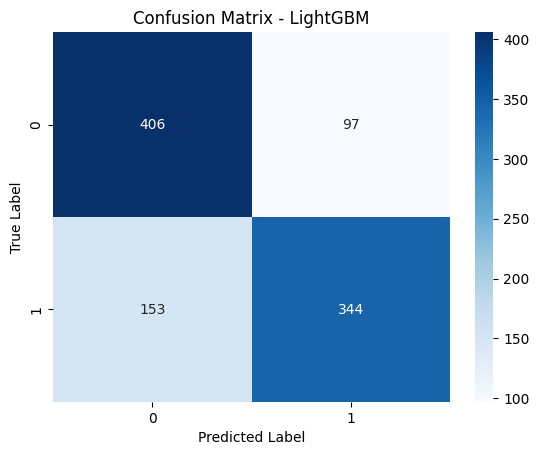

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Predict on test data
y_pred_lgb = lgb_model.predict(X_final)

# Print accuracy & classification report
print("LGBM Accuracy:", accuracy_score(y_cleaned, y_pred_lgb))
print(classification_report(y_cleaned, y_pred_lgb))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_cleaned, y_pred_lgb)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - LightGBM")
plt.show()


In [15]:
lgb_model = LGBMClassifier(n_estimators=300, max_depth=4, learning_rate=0.2, class_weight={0: 1, 1: 1.5})
lgb_model.fit(X_final, y_cleaned)

[LightGBM] [Info] Number of positive: 497, number of negative: 503
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 97873
[LightGBM] [Info] Number of data points in the train set: 1000, number of used features: 385
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.597117 -> initscore=0.393465
[LightGBM] [Info] Start training from score 0.393465
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

LGBMClassifier(class_weight={0: 1, 1: 1.5}, learning_rate=0.2, max_depth=4,
               n_estimators=300)

In [16]:
df["domain_shared"] = df["email_domain"].apply(lambda x: 1 if x in ["support.com", "info.com"] else 0)
df["signature_length"] = df["signature_text"].apply(lambda x: len(x.split()))

# Add these features to training
X_numeric = df[["email_domain_enc", "name_length", "title_length", "domain_shared", "signature_length"]].values


In [17]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(iterations=300, depth=4, learning_rate=0.2)
cat_model.fit(X_final, y_cleaned)


0:	learn: 0.6879673	total: 147ms	remaining: 44.1s
1:	learn: 0.6831337	total: 157ms	remaining: 23.4s
2:	learn: 0.6787875	total: 167ms	remaining: 16.5s
3:	learn: 0.6765743	total: 176ms	remaining: 13.1s
4:	learn: 0.6738726	total: 184ms	remaining: 10.9s
5:	learn: 0.6706024	total: 188ms	remaining: 9.23s
6:	learn: 0.6671537	total: 193ms	remaining: 8.07s
7:	learn: 0.6654577	total: 197ms	remaining: 7.19s
8:	learn: 0.6637830	total: 202ms	remaining: 6.53s
9:	learn: 0.6622286	total: 206ms	remaining: 5.98s
10:	learn: 0.6570288	total: 211ms	remaining: 5.53s
11:	learn: 0.6552213	total: 214ms	remaining: 5.13s
12:	learn: 0.6511792	total: 217ms	remaining: 4.8s
13:	learn: 0.6485017	total: 221ms	remaining: 4.52s
14:	learn: 0.6456924	total: 225ms	remaining: 4.27s
15:	learn: 0.6433128	total: 228ms	remaining: 4.04s
16:	learn: 0.6402815	total: 231ms	remaining: 3.85s
17:	learn: 0.6388103	total: 235ms	remaining: 3.67s
18:	learn: 0.6373530	total: 238ms	remaining: 3.52s
19:	learn: 0.6361251	total: 241ms	remainin

In [18]:
y_pred_cat = cat_model.predict(X_final)

from sklearn.metrics import classification_report, accuracy_score

print("CatBoost Accuracy:", accuracy_score(y_cleaned, y_pred_cat))
print(classification_report(y_cleaned, y_pred_cat))

CatBoost Accuracy: 0.75
              precision    recall  f1-score   support

           0       0.73      0.81      0.76       503
           1       0.78      0.69      0.73       497

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000



C:\Users\Piyush\AppData\Local\Temp\ipykernel_14692\1894390925.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predictions_series, palette="viridis")
d:\Dev\Tools\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
d:\Dev\Tools\Python\Python312\Lib\site-packages\seaborn\_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


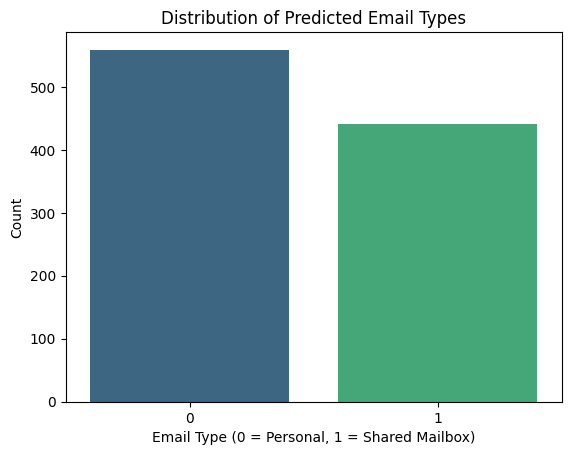

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert predictions to a Pandas Series for visualization
predictions_series = pd.Series(y_pred_cat, name="Predicted Category")

# Plot the count of each class (0 = Personal, 1 = Shared Mailbox)
sns.countplot(x=predictions_series, palette="viridis")
plt.xlabel("Email Type (0 = Personal, 1 = Shared Mailbox)")
plt.ylabel("Count")
plt.title("Distribution of Predicted Email Types")
plt.show()


In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_final was transformed from a DataFrame and we need the email column from the original dataset
if isinstance(X_final, pd.DataFrame) and "email" in X_final.columns:
    emails = X_final["email"]
elif "email" in df.columns:  # Check the original DataFrame
    emails = df["email"].iloc[:len(y_pred_cat)].values  # Match length of predictions
else:
    raise ValueError("Could not find 'email' column in available datasets.")

# Create DataFrame with unique emails and predictions
unique_emails_df = pd.DataFrame({"email": emails, "prediction": y_pred_cat}).drop_duplicates(subset="email").reset_index(drop=True)

# Plot line graph
plt.figure(figsize=(15, 6))
plt.plot(unique_emails_df.index, unique_emails_df["prediction"], marker='o', linestyle='-', color='b', alpha=0.6, label="Predicted Label")

# Annotate each point with the email address
for i, email in enumerate(unique_emails_df["email"]):
    plt.text(i, unique_emails_df["prediction"].iloc[i], email, fontsize=9, rotation=45, ha='right')

# Add horizontal line at 0.5 for separation
plt.axhline(y=0.5, color='r', linestyle="--", label="Threshold Between Classes")

# Labels & title
plt.xlabel("Unique Email Index")
plt.ylabel("Prediction (0 = Personal, 1 = Shared Mailbox)")
plt.title("Email Classification with Unique Emails Labeled")
plt.xticks(rotation=90)
plt.legend()
plt.show()


ValueError: Could not find 'email' column in available datasets.